In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

TensorFlow 1.x selected.
170500096/170498071 [==============================] - 4s 0us/step
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 1, trainning accuracy， 0.113281 , testing accuracy， 0.1019 , loss 81.2704  ,lr 0.000999799
step 101, trainning accuracy， 0.382812 , testing accuracy， 0.3214 , loss 51.2619  ,lr 0.000979903
step 201, trainning accuracy， 0.363281 , testing accuracy， 0.366 , loss 30.4797  ,l

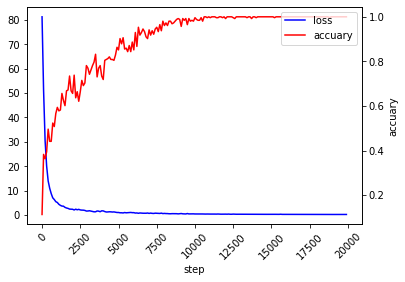

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.layers as layers
import pickle
import numpy as np
import os
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size=256

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#随机旋转，裁切等数据增强
def data_enhace(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, max_delta=0.2)
    x = tf.image.random_brightness(x, max_delta=0.7)
    result = tf.image.random_contrast(x, lower=0.2, upper=1.8)
    return result

#mixup数据增强
def criterion(batch_x, batch_y, batch_size,alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = tf.random_shuffle(batch_size)
    mixed_batchx = lam * batch_x + (1 - lam) * batch_x[index, :]

    batch_y_= lam*batch_y+(1-lam)*batch_y[index]
    return mixed_batchx,batch_y_

#本地载入cifar10数据集
def load_cifar10_batch(cifar10_dataset_folder_path,batch_id):

    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id),mode='rb') as file:
        batch = pickle.load(file, encoding = 'latin1')

    # features and labels
    features = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']

    return  features, labels

#在线载入cifar10数据集
def load_cifar10_batch_online():
    (x_Train, y_Train), (x_Test, y_Test)=cifar10.load_data()
    return x_Train,y_Train,x_Test,y_Test

#cifar10数据集读取器
class Cifar10DataReader():
    def __init__(self, cifar_folder=None, onehot=True):
        self.cifar_folder = cifar_folder
        self.onehot = onehot
        self.data_label_train = None
        self.data_label_test = None
        self.batch_index = 0

        if cifar_folder==None:#在线
            x_train, y_train,x_test,y_test=load_cifar10_batch_online()
            self.data_label_train = list(zip(x_train, y_train))
            self.data_label_test = list(zip(x_test, y_test))
            np.random.shuffle(self.data_label_train)

        else:#本地
            x_train, y_train = load_cifar10_batch(self.cifar_folder, 1)
            for i in range(2,6):
                features,labels = load_cifar10_batch(self.cifar_folder, i)
                x_train, y_train = np.concatenate([x_train, features]),np.concatenate([y_train, labels])
            self.data_label_train = list(zip(x_train, y_train))
            np.random.shuffle(self.data_label_train)

            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

    #批次读取训练集数据
    def next_train_data(self, batch_size=100):
        if self.batch_index < len(self.data_label_train) // batch_size:
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)
        else:
            self.batch_index = 0
            np.random.shuffle(self.data_label_train)
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)

    #读取所有训练集数据
    def all_train_data(self):
        np.random.shuffle(self.data_label_train)
        datum = self.data_label_train
        return self._decode(datum, self.onehot)

    #独热编码
    def _decode(self, datum, onehot):
        rdata = list()
        rlabel = list()
        if onehot:
            for d, l in datum:
                rdata.append(d)
                hot = np.zeros(10)
                hot[int(l)] = 1
                rlabel.append(hot)
        else:
            for d, l in datum:
                rdata.append(d)
                rlabel.append(int(l))
        return rdata, rlabel

    #批次读取测试集数据
    def next_test_data(self, batch_size=100):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test[0:batch_size]

        return self._decode(datum, self.onehot)

    #读取所有测试集数据
    def all_test_data(self):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test

        return self._decode(datum, self.onehot)


#网络结构
def weight_variable(shape):
    weights = tf.get_variable("weights", shape, initializer=tf.contrib.keras.initializers.he_normal())
    #加入l2正则化
    regular=tf.multiply(tf.nn.l2_loss(weights),0.005,name='regular')
    tf.add_to_collection('losses',regular)
    return weights
def bias_variable(shape):
    biases = tf.get_variable("biases", shape, initializer=tf.constant_initializer(0.0))
    return biases
def conv_layer(x, w, b, name, strides, padding = 'SAME'):
    with tf.variable_scope(name):
        w = weight_variable(w)
        b = bias_variable(b)
        conv_and_biased = tf.nn.conv2d(x, w, strides = strides, padding = padding, name = name) + b
    return conv_and_biased
def batch_normalization(inputs, scope, is_training=True, need_relu=True):
    bn = tf.contrib.layers.batch_norm(inputs,
        decay=0.999,
        center=True,
        scale=True,  # 可以让学生实验True和False的区别。
        epsilon=0.001,
        activation_fn=None,
        param_initializers=None,
        param_regularizers=None,
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        is_training=is_training,  # 可以让学生实验True和False的区别。
        reuse=None,
        variables_collections=None,
        outputs_collections=None,
        trainable=True,
        batch_weights=None,
        fused=False,
        data_format='NHWC',
        zero_debias_moving_mean=False,
        scope=scope,
        renorm=False,
        renorm_clipping=None,
        renorm_decay=0.99)
    if need_relu:
        bn = tf.nn.relu(bn, name='relu')
    return bn
def maxpooling(x,kernal_size, strides, name):  # 最大池化，前面的是核大小，一般为[1, 2, 2, 1]，后面的strides指的是步长，如[1, 2, 2, 1]。
    return tf.nn.max_pool(x, ksize=kernal_size, strides=strides, padding='SAME',name = name)
def avg_pool(input_feats, k):
    ksize = [1, k, k, 1]
    strides = [1, k, k, 1]
    padding = 'VALID'
    output = tf.nn.avg_pool(input_feats, ksize, strides, padding)  # 平均池化
    return output
def conv_block(input_tensor, kernel_size, filters, stage, block, train_flag,stride2=False):
    nb_filter1, nb_filter2, nb_filter3 = filters  # nb_filter1/2/3分别是64/64/256，三个整数。
    conv_name_base = 'res' + str(stage) + block + '_branch'  # 'res2a_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'  # 'bn2a_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    if stride2==False:
        stride_for_first_conv = [1, 1, 1, 1]  # 。
    else:
        stride_for_first_conv = [1, 2, 2, 1]
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x = batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    shortcut = conv_layer(input_tensor, [1, 1, input_layers, nb_filter3], [nb_filter3], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '1')
    shortcut = batch_normalization(shortcut, scope=bn_name_base + '1', is_training=train_flag)
    x = tf.add(x, shortcut)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def identity_block(input_tensor, kernel_size, filters, stage, block, train_flag):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x =  batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    x = tf.add(x, input_tensor)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def resnet_graph(input_image, architecture,train_flag=True, stage5=False,ttf=True):  # 残差网络函数
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    paddings = tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]])  # 上下左右各补3个0。
    x = tf.pad(input_image, paddings, "CONSTANT")
    w = weight_variable([7, 7, 3, 64])
    b = bias_variable([64])  #
    x = tf.nn.conv2d(x, w, strides = [1, 2, 2, 1], padding = 'VALID', name = 'conv_1') + b
    x = batch_normalization(x, scope='bn_conv1', is_training=train_flag, need_relu=True)
    C1 = x = maxpooling(x, [1, 3, 3, 1], [1, 2, 2, 1], name='stage1')
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', train_flag=train_flag)  # 结构块。
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_flag=train_flag)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_flag=train_flag, stride2=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_flag=train_flag)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_flag=train_flag)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_flag=train_flag, stride2=True)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]  # block_count=22，即，下句for循环的range是0~22，正好是加23个层。
    for i in range(block_count):  # 加22个层，都是用identity_block函数加。
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_flag=train_flag)
    C4 = x  #
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_flag=train_flag, stride2=True)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_flag=train_flag)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_flag=train_flag)
        output=avg_pool(C5,1)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)#加入dropout
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)
    else:
        C5 = None
        output=avg_pool(C4,2)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)

    return [C1, C2, C3, C4, C5,output]



filepath='C:/Users/zy109/Desktop/1/data/cifar-10-batches-py'
model_save_path='C:/Users/zy109/Desktop/1/cifar10'
data=Cifar10DataReader()
sess=tf.InteractiveSession()

#指数衰减学习率
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(learning_rate=0.001, global_step=global_step, decay_steps=50, decay_rate=0.99, staircase=False)

#占位符
input_image=tf.placeholder(tf.float32,[None,32,32,3])
y_=tf.placeholder(tf.float32,[None,10])
tf_is_train=tf.placeholder(tf.bool,None)
input_image=data_enhace(input_image)#数据增强
input_image,y_=criterion(input_image,y_,batch_size)#mixup

[C1,C2,C3,C4,C5,output]=resnet_graph(input_image,'resnet50',ttf=tf_is_train)

#交叉熵损失
cross_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=output))

tf.add_to_collection('losses',cross_loss)
loss=tf.add_n(tf.get_collection('losses'))
train_step=tf.train.AdamOptimizer(lr).minimize(loss,global_step=global_step)

#正确率
correct_prediction=tf.equal(tf.argmax(output,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))



# 开始训练
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
#读取已经训练好的权重
ckpt = tf.train.get_checkpoint_state(model_save_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

#加载测试集数据
test_data=data.all_test_data()
x_test=np.array(test_data[0])/255
y_test=np.array(test_data[1])

total_loss=[]
total_acc=[]
total_step=[]


# 训练
for i in range(20000):

    #逐批加载训练集数据
    train_data=data.next_train_data(batch_size)
    x_train=np.array(train_data[0])/255
    y_train=np.array(train_data[1])

    train_step.run(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

    if i % 100 == 0:
        # 测试准确率
        train_accuracy = accuracy.eval(feed_dict={input_image: x_train,y_: y_train,tf_is_train:False})
        test_accuracy = accuracy.eval(feed_dict={input_image: x_test,y_: y_test,tf_is_train:False})
        # 该次训练的损失
        loss_value = loss.eval(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

        global_var=sess.run(global_step)
        lr_val=sess.run(lr)
        print("step %d, trainning accuracy， %g , testing accuracy， %g , loss %g  ,lr %g" % (global_var, train_accuracy,test_accuracy, loss_value,lr_val))
        total_step.append(i)
        total_loss.append(loss_value)
        total_acc.append(train_accuracy)



#保存模型
save_path = saver.save(sess,"./cifar10/model.ckpt")
print("save model:{0} Finished".format(save_path))
np.save("cifar10_step",total_step)
np.save("cifar10_loss",total_loss)
np.save("cifar10_acc",total_acc)

#测试
y_log_predict=output.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
test_accuracy = accuracy.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
print("test accuracy %g" % test_accuracy)



# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), y_log_predict.argmax(axis=1))


for i in range(len(y_log_predict)):
        max_value=max(y_log_predict[i])
        for j in range(len(y_log_predict[i])):
            if max_value==y_log_predict[i][j]:
                y_log_predict[i][j]=1
            else:
                y_log_predict[i][j]=0

# 精确率
from sklearn.metrics import precision_score
ps=precision_score(y_test, y_log_predict,average=None)
np.save("cifar10_precision_score",ps)

#召回率
from sklearn.metrics import recall_score
rs=recall_score(y_test, y_log_predict,average=None)
np.save("cifar10_recall_score",rs)

print("precision score:",ps)
print("recall score:",rs)

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(total_step, total_loss, color="blue", label="loss")
ax1.set_xlabel("step")


ax2 = ax1.twinx()
ax2.plot(total_step, total_acc, color="red", label="accuary")
ax2.set_ylabel("accuary")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()


TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 1, trainning accuracy， 0.171875 , testing accuracy， 0.1221 , loss 80.561  ,lr 0.000999799
step 101, trainning accuracy， 0.332031 , testing accuracy， 0.2949 , loss 52.5471  ,lr 0.000979903
step 201, trainning accuracy， 0.367188 , testing accuracy， 0.3905 , loss 31.7227  ,lr 0.000960403
step 301, trainning accuracy， 0.382812 , testing accu

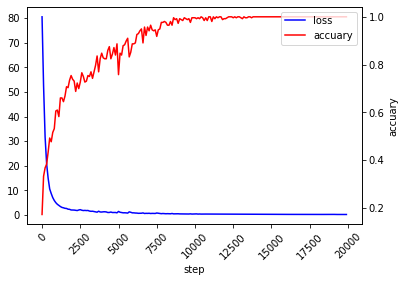

In [1]:
# is_training=False 37min
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.layers as layers
import pickle
import numpy as np
import os
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size=256

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#随机旋转，裁切等数据增强
def data_enhace(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, max_delta=0.2)
    x = tf.image.random_brightness(x, max_delta=0.7)
    result = tf.image.random_contrast(x, lower=0.2, upper=1.8)
    return result

#mixup数据增强
def criterion(batch_x, batch_y, batch_size,alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = tf.random_shuffle(batch_size)
    mixed_batchx = lam * batch_x + (1 - lam) * batch_x[index, :]

    batch_y_= lam*batch_y+(1-lam)*batch_y[index]
    return mixed_batchx,batch_y_

#本地载入cifar10数据集
def load_cifar10_batch(cifar10_dataset_folder_path,batch_id):

    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id),mode='rb') as file:
        batch = pickle.load(file, encoding = 'latin1')

    # features and labels
    features = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']

    return  features, labels

#在线载入cifar10数据集
def load_cifar10_batch_online():
    (x_Train, y_Train), (x_Test, y_Test)=cifar10.load_data()
    return x_Train,y_Train,x_Test,y_Test

#cifar10数据集读取器
class Cifar10DataReader():
    def __init__(self, cifar_folder=None, onehot=True):
        self.cifar_folder = cifar_folder
        self.onehot = onehot
        self.data_label_train = None
        self.data_label_test = None
        self.batch_index = 0

        if cifar_folder==None:#在线
            x_train, y_train,x_test,y_test=load_cifar10_batch_online()
            self.data_label_train = list(zip(x_train, y_train))
            self.data_label_test = list(zip(x_test, y_test))
            np.random.shuffle(self.data_label_train)

        else:#本地
            x_train, y_train = load_cifar10_batch(self.cifar_folder, 1)
            for i in range(2,6):
                features,labels = load_cifar10_batch(self.cifar_folder, i)
                x_train, y_train = np.concatenate([x_train, features]),np.concatenate([y_train, labels])
            self.data_label_train = list(zip(x_train, y_train))
            np.random.shuffle(self.data_label_train)

            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

    #批次读取训练集数据
    def next_train_data(self, batch_size=100):
        if self.batch_index < len(self.data_label_train) // batch_size:
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)
        else:
            self.batch_index = 0
            np.random.shuffle(self.data_label_train)
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)

    #读取所有训练集数据
    def all_train_data(self):
        np.random.shuffle(self.data_label_train)
        datum = self.data_label_train
        return self._decode(datum, self.onehot)

    #独热编码
    def _decode(self, datum, onehot):
        rdata = list()
        rlabel = list()
        if onehot:
            for d, l in datum:
                rdata.append(d)
                hot = np.zeros(10)
                hot[int(l)] = 1
                rlabel.append(hot)
        else:
            for d, l in datum:
                rdata.append(d)
                rlabel.append(int(l))
        return rdata, rlabel

    #批次读取测试集数据
    def next_test_data(self, batch_size=100):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test[0:batch_size]

        return self._decode(datum, self.onehot)

    #读取所有测试集数据
    def all_test_data(self):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test

        return self._decode(datum, self.onehot)


#网络结构
def weight_variable(shape):
    weights = tf.get_variable("weights", shape, initializer=tf.contrib.keras.initializers.he_normal())
    #加入l2正则化
    regular=tf.multiply(tf.nn.l2_loss(weights),0.005,name='regular')
    tf.add_to_collection('losses',regular)
    return weights
def bias_variable(shape):
    biases = tf.get_variable("biases", shape, initializer=tf.constant_initializer(0.0))
    return biases
def conv_layer(x, w, b, name, strides, padding = 'SAME'):
    with tf.variable_scope(name):
        w = weight_variable(w)
        b = bias_variable(b)
        conv_and_biased = tf.nn.conv2d(x, w, strides = strides, padding = padding, name = name) + b
    return conv_and_biased
def batch_normalization(inputs, scope, is_training=False, need_relu=True):
    bn = tf.contrib.layers.batch_norm(inputs,
        decay=0.999,
        center=True,
        scale=True,  # 可以让学生实验True和False的区别。
        epsilon=0.001,
        activation_fn=None,
        param_initializers=None,
        param_regularizers=None,
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        is_training=is_training,  # 可以让学生实验True和False的区别。
        reuse=None,
        variables_collections=None,
        outputs_collections=None,
        trainable=True,
        batch_weights=None,
        fused=False,
        data_format='NHWC',
        zero_debias_moving_mean=False,
        scope=scope,
        renorm=False,
        renorm_clipping=None,
        renorm_decay=0.99)
    if need_relu:
        bn = tf.nn.relu(bn, name='relu')
    return bn
def maxpooling(x,kernal_size, strides, name):  # 最大池化，前面的是核大小，一般为[1, 2, 2, 1]，后面的strides指的是步长，如[1, 2, 2, 1]。
    return tf.nn.max_pool(x, ksize=kernal_size, strides=strides, padding='SAME',name = name)
def avg_pool(input_feats, k):
    ksize = [1, k, k, 1]
    strides = [1, k, k, 1]
    padding = 'VALID'
    output = tf.nn.avg_pool(input_feats, ksize, strides, padding)  # 平均池化
    return output
def conv_block(input_tensor, kernel_size, filters, stage, block, train_flag,stride2=False):
    nb_filter1, nb_filter2, nb_filter3 = filters  # nb_filter1/2/3分别是64/64/256，三个整数。
    conv_name_base = 'res' + str(stage) + block + '_branch'  # 'res2a_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'  # 'bn2a_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    if stride2==False:
        stride_for_first_conv = [1, 1, 1, 1]  # 。
    else:
        stride_for_first_conv = [1, 2, 2, 1]
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x = batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    shortcut = conv_layer(input_tensor, [1, 1, input_layers, nb_filter3], [nb_filter3], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '1')
    shortcut = batch_normalization(shortcut, scope=bn_name_base + '1', is_training=train_flag)
    x = tf.add(x, shortcut)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def identity_block(input_tensor, kernel_size, filters, stage, block, train_flag):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x =  batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    x = tf.add(x, input_tensor)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def resnet_graph(input_image, architecture,train_flag=True, stage5=False,ttf=True):  # 残差网络函数
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    paddings = tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]])  # 上下左右各补3个0。
    x = tf.pad(input_image, paddings, "CONSTANT")
    w = weight_variable([7, 7, 3, 64])
    b = bias_variable([64])  #
    x = tf.nn.conv2d(x, w, strides = [1, 2, 2, 1], padding = 'VALID', name = 'conv_1') + b
    x = batch_normalization(x, scope='bn_conv1', is_training=train_flag, need_relu=True)
    C1 = x = maxpooling(x, [1, 3, 3, 1], [1, 2, 2, 1], name='stage1')
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', train_flag=train_flag)  # 结构块。
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_flag=train_flag)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_flag=train_flag, stride2=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_flag=train_flag)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_flag=train_flag)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_flag=train_flag, stride2=True)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]  # block_count=22，即，下句for循环的range是0~22，正好是加23个层。
    for i in range(block_count):  # 加22个层，都是用identity_block函数加。
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_flag=train_flag)
    C4 = x  #
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_flag=train_flag, stride2=True)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_flag=train_flag)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_flag=train_flag)
        output=avg_pool(C5,1)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)#加入dropout
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)
    else:
        C5 = None
        output=avg_pool(C4,2)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)

    return [C1, C2, C3, C4, C5,output]



filepath='C:/Users/zy109/Desktop/1/data/cifar-10-batches-py'
model_save_path='C:/Users/zy109/Desktop/1/cifar10'
data=Cifar10DataReader()
sess=tf.InteractiveSession()

#指数衰减学习率
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(learning_rate=0.001, global_step=global_step, decay_steps=50, decay_rate=0.99, staircase=False)

#占位符
input_image=tf.placeholder(tf.float32,[None,32,32,3])
y_=tf.placeholder(tf.float32,[None,10])
tf_is_train=tf.placeholder(tf.bool,None)
input_image=data_enhace(input_image)#数据增强
input_image,y_=criterion(input_image,y_,batch_size)#mixup

[C1,C2,C3,C4,C5,output]=resnet_graph(input_image,'resnet50',ttf=tf_is_train)

#交叉熵损失
cross_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=output))

tf.add_to_collection('losses',cross_loss)
loss=tf.add_n(tf.get_collection('losses'))
train_step=tf.train.AdamOptimizer(lr).minimize(loss,global_step=global_step)

#正确率
correct_prediction=tf.equal(tf.argmax(output,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))



# 开始训练
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
#读取已经训练好的权重
ckpt = tf.train.get_checkpoint_state(model_save_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

#加载测试集数据
test_data=data.all_test_data()
x_test=np.array(test_data[0])/255
y_test=np.array(test_data[1])

total_loss=[]
total_acc=[]
total_step=[]


# 训练
for i in range(20000):

    #逐批加载训练集数据
    train_data=data.next_train_data(batch_size)
    x_train=np.array(train_data[0])/255
    y_train=np.array(train_data[1])

    train_step.run(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

    if i % 100 == 0:
        # 测试准确率
        train_accuracy = accuracy.eval(feed_dict={input_image: x_train,y_: y_train,tf_is_train:False})
        test_accuracy = accuracy.eval(feed_dict={input_image: x_test,y_: y_test,tf_is_train:False})
        # 该次训练的损失
        loss_value = loss.eval(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

        global_var=sess.run(global_step)
        lr_val=sess.run(lr)
        print("step %d, trainning accuracy， %g , testing accuracy， %g , loss %g  ,lr %g" % (global_var, train_accuracy,test_accuracy, loss_value,lr_val))
        total_step.append(i)
        total_loss.append(loss_value)
        total_acc.append(train_accuracy)



#保存模型
save_path = saver.save(sess,"./cifar10/model.ckpt")
print("save model:{0} Finished".format(save_path))
np.save("cifar10_step",total_step)
np.save("cifar10_loss",total_loss)
np.save("cifar10_acc",total_acc)

#测试
y_log_predict=output.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
test_accuracy = accuracy.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
print("test accuracy %g" % test_accuracy)



# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), y_log_predict.argmax(axis=1))


for i in range(len(y_log_predict)):
        max_value=max(y_log_predict[i])
        for j in range(len(y_log_predict[i])):
            if max_value==y_log_predict[i][j]:
                y_log_predict[i][j]=1
            else:
                y_log_predict[i][j]=0

# 精确率
from sklearn.metrics import precision_score
ps=precision_score(y_test, y_log_predict,average=None)
np.save("cifar10_precision_score",ps)

#召回率
from sklearn.metrics import recall_score
rs=recall_score(y_test, y_log_predict,average=None)
np.save("cifar10_recall_score",rs)

print("precision score:",ps)
print("recall score:",rs)

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(total_step, total_loss, color="blue", label="loss")
ax1.set_xlabel("step")


ax2 = ax1.twinx()
ax2.plot(total_step, total_acc, color="red", label="accuary")
ax2.set_ylabel("accuary")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()


TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 1, trainning accuracy， 0.15625 , testing accuracy， 0.117 , loss 80.8099  ,lr 0.000999799
step 101, trainning accuracy， 0.289062 , testing accuracy， 0.3015 , loss 51.1716  ,lr 0.000979903
step 201, trainning accuracy， 0.449219 , testing accuracy， 0.3854 , loss 30.1415  ,lr 0.000960403
step 301, trainning accuracy， 0.441406 , testing accur

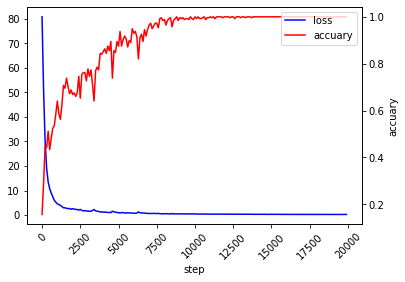

In [1]:
#  scale=False 36min
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.layers as layers
import pickle
import numpy as np
import os
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size=256

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#随机旋转，裁切等数据增强
def data_enhace(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, max_delta=0.2)
    x = tf.image.random_brightness(x, max_delta=0.7)
    result = tf.image.random_contrast(x, lower=0.2, upper=1.8)
    return result

#mixup数据增强
def criterion(batch_x, batch_y, batch_size,alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = tf.random_shuffle(batch_size)
    mixed_batchx = lam * batch_x + (1 - lam) * batch_x[index, :]

    batch_y_= lam*batch_y+(1-lam)*batch_y[index]
    return mixed_batchx,batch_y_

#本地载入cifar10数据集
def load_cifar10_batch(cifar10_dataset_folder_path,batch_id):

    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id),mode='rb') as file:
        batch = pickle.load(file, encoding = 'latin1')

    # features and labels
    features = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']

    return  features, labels

#在线载入cifar10数据集
def load_cifar10_batch_online():
    (x_Train, y_Train), (x_Test, y_Test)=cifar10.load_data()
    return x_Train,y_Train,x_Test,y_Test

#cifar10数据集读取器
class Cifar10DataReader():
    def __init__(self, cifar_folder=None, onehot=True):
        self.cifar_folder = cifar_folder
        self.onehot = onehot
        self.data_label_train = None
        self.data_label_test = None
        self.batch_index = 0

        if cifar_folder==None:#在线
            x_train, y_train,x_test,y_test=load_cifar10_batch_online()
            self.data_label_train = list(zip(x_train, y_train))
            self.data_label_test = list(zip(x_test, y_test))
            np.random.shuffle(self.data_label_train)

        else:#本地
            x_train, y_train = load_cifar10_batch(self.cifar_folder, 1)
            for i in range(2,6):
                features,labels = load_cifar10_batch(self.cifar_folder, i)
                x_train, y_train = np.concatenate([x_train, features]),np.concatenate([y_train, labels])
            self.data_label_train = list(zip(x_train, y_train))
            np.random.shuffle(self.data_label_train)

            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

    #批次读取训练集数据
    def next_train_data(self, batch_size=100):
        if self.batch_index < len(self.data_label_train) // batch_size:
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)
        else:
            self.batch_index = 0
            np.random.shuffle(self.data_label_train)
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)

    #读取所有训练集数据
    def all_train_data(self):
        np.random.shuffle(self.data_label_train)
        datum = self.data_label_train
        return self._decode(datum, self.onehot)

    #独热编码
    def _decode(self, datum, onehot):
        rdata = list()
        rlabel = list()
        if onehot:
            for d, l in datum:
                rdata.append(d)
                hot = np.zeros(10)
                hot[int(l)] = 1
                rlabel.append(hot)
        else:
            for d, l in datum:
                rdata.append(d)
                rlabel.append(int(l))
        return rdata, rlabel

    #批次读取测试集数据
    def next_test_data(self, batch_size=100):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test[0:batch_size]

        return self._decode(datum, self.onehot)

    #读取所有测试集数据
    def all_test_data(self):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test

        return self._decode(datum, self.onehot)


#网络结构
def weight_variable(shape):
    weights = tf.get_variable("weights", shape, initializer=tf.contrib.keras.initializers.he_normal())
    #加入l2正则化
    regular=tf.multiply(tf.nn.l2_loss(weights),0.005,name='regular')
    tf.add_to_collection('losses',regular)
    return weights
def bias_variable(shape):
    biases = tf.get_variable("biases", shape, initializer=tf.constant_initializer(0.0))
    return biases
def conv_layer(x, w, b, name, strides, padding = 'SAME'):
    with tf.variable_scope(name):
        w = weight_variable(w)
        b = bias_variable(b)
        conv_and_biased = tf.nn.conv2d(x, w, strides = strides, padding = padding, name = name) + b
    return conv_and_biased
def batch_normalization(inputs, scope, is_training=True, need_relu=True):
    bn = tf.contrib.layers.batch_norm(inputs,
        decay=0.999,
        center=True,
        scale=False,  # 可以让学生实验True和False的区别。
        epsilon=0.001,
        activation_fn=None,
        param_initializers=None,
        param_regularizers=None,
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        is_training=is_training,  # 可以让学生实验True和False的区别。
        reuse=None,
        variables_collections=None,
        outputs_collections=None,
        trainable=True,
        batch_weights=None,
        fused=False,
        data_format='NHWC',
        zero_debias_moving_mean=False,
        scope=scope,
        renorm=False,
        renorm_clipping=None,
        renorm_decay=0.99)
    if need_relu:
        bn = tf.nn.relu(bn, name='relu')
    return bn
def maxpooling(x,kernal_size, strides, name):  # 最大池化，前面的是核大小，一般为[1, 2, 2, 1]，后面的strides指的是步长，如[1, 2, 2, 1]。
    return tf.nn.max_pool(x, ksize=kernal_size, strides=strides, padding='SAME',name = name)
def avg_pool(input_feats, k):
    ksize = [1, k, k, 1]
    strides = [1, k, k, 1]
    padding = 'VALID'
    output = tf.nn.avg_pool(input_feats, ksize, strides, padding)  # 平均池化
    return output
def conv_block(input_tensor, kernel_size, filters, stage, block, train_flag,stride2=False):
    nb_filter1, nb_filter2, nb_filter3 = filters  # nb_filter1/2/3分别是64/64/256，三个整数。
    conv_name_base = 'res' + str(stage) + block + '_branch'  # 'res2a_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'  # 'bn2a_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    if stride2==False:
        stride_for_first_conv = [1, 1, 1, 1]  # 。
    else:
        stride_for_first_conv = [1, 2, 2, 1]
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x = batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    shortcut = conv_layer(input_tensor, [1, 1, input_layers, nb_filter3], [nb_filter3], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '1')
    shortcut = batch_normalization(shortcut, scope=bn_name_base + '1', is_training=train_flag)
    x = tf.add(x, shortcut)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def identity_block(input_tensor, kernel_size, filters, stage, block, train_flag):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x =  batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    x = tf.add(x, input_tensor)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def resnet_graph(input_image, architecture,train_flag=True, stage5=False,ttf=True):  # 残差网络函数
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    paddings = tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]])  # 上下左右各补3个0。
    x = tf.pad(input_image, paddings, "CONSTANT")
    w = weight_variable([7, 7, 3, 64])
    b = bias_variable([64])  #
    x = tf.nn.conv2d(x, w, strides = [1, 2, 2, 1], padding = 'VALID', name = 'conv_1') + b
    x = batch_normalization(x, scope='bn_conv1', is_training=train_flag, need_relu=True)
    C1 = x = maxpooling(x, [1, 3, 3, 1], [1, 2, 2, 1], name='stage1')
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', train_flag=train_flag)  # 结构块。
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_flag=train_flag)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_flag=train_flag, stride2=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_flag=train_flag)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_flag=train_flag)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_flag=train_flag, stride2=True)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]  # block_count=22，即，下句for循环的range是0~22，正好是加23个层。
    for i in range(block_count):  # 加22个层，都是用identity_block函数加。
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_flag=train_flag)
    C4 = x  #
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_flag=train_flag, stride2=True)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_flag=train_flag)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_flag=train_flag)
        output=avg_pool(C5,1)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)#加入dropout
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)
    else:
        C5 = None
        output=avg_pool(C4,2)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)

    return [C1, C2, C3, C4, C5,output]



filepath='C:/Users/zy109/Desktop/1/data/cifar-10-batches-py'
model_save_path='C:/Users/zy109/Desktop/1/cifar10'
data=Cifar10DataReader()
sess=tf.InteractiveSession()

#指数衰减学习率
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(learning_rate=0.001, global_step=global_step, decay_steps=50, decay_rate=0.99, staircase=False)

#占位符
input_image=tf.placeholder(tf.float32,[None,32,32,3])
y_=tf.placeholder(tf.float32,[None,10])
tf_is_train=tf.placeholder(tf.bool,None)
input_image=data_enhace(input_image)#数据增强
input_image,y_=criterion(input_image,y_,batch_size)#mixup

[C1,C2,C3,C4,C5,output]=resnet_graph(input_image,'resnet50',ttf=tf_is_train)

#交叉熵损失
cross_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=output))

tf.add_to_collection('losses',cross_loss)
loss=tf.add_n(tf.get_collection('losses'))
train_step=tf.train.AdamOptimizer(lr).minimize(loss,global_step=global_step)

#正确率
correct_prediction=tf.equal(tf.argmax(output,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))



# 开始训练
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
#读取已经训练好的权重
ckpt = tf.train.get_checkpoint_state(model_save_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

#加载测试集数据
test_data=data.all_test_data()
x_test=np.array(test_data[0])/255
y_test=np.array(test_data[1])

total_loss=[]
total_acc=[]
total_step=[]


# 训练
for i in range(20000):

    #逐批加载训练集数据
    train_data=data.next_train_data(batch_size)
    x_train=np.array(train_data[0])/255
    y_train=np.array(train_data[1])

    train_step.run(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

    if i % 100 == 0:
        # 测试准确率
        train_accuracy = accuracy.eval(feed_dict={input_image: x_train,y_: y_train,tf_is_train:False})
        test_accuracy = accuracy.eval(feed_dict={input_image: x_test,y_: y_test,tf_is_train:False})
        # 该次训练的损失
        loss_value = loss.eval(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

        global_var=sess.run(global_step)
        lr_val=sess.run(lr)
        print("step %d, trainning accuracy， %g , testing accuracy， %g , loss %g  ,lr %g" % (global_var, train_accuracy,test_accuracy, loss_value,lr_val))
        total_step.append(i)
        total_loss.append(loss_value)
        total_acc.append(train_accuracy)



#保存模型
save_path = saver.save(sess,"./cifar10/model.ckpt")
print("save model:{0} Finished".format(save_path))
np.save("cifar10_step",total_step)
np.save("cifar10_loss",total_loss)
np.save("cifar10_acc",total_acc)

#测试
y_log_predict=output.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
test_accuracy = accuracy.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
print("test accuracy %g" % test_accuracy)



# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), y_log_predict.argmax(axis=1))


for i in range(len(y_log_predict)):
        max_value=max(y_log_predict[i])
        for j in range(len(y_log_predict[i])):
            if max_value==y_log_predict[i][j]:
                y_log_predict[i][j]=1
            else:
                y_log_predict[i][j]=0

# 精确率
from sklearn.metrics import precision_score
ps=precision_score(y_test, y_log_predict,average=None)
np.save("cifar10_precision_score",ps)

#召回率
from sklearn.metrics import recall_score
rs=recall_score(y_test, y_log_predict,average=None)
np.save("cifar10_recall_score",rs)

print("precision score:",ps)
print("recall score:",rs)

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(total_step, total_loss, color="blue", label="loss")
ax1.set_xlabel("step")


ax2 = ax1.twinx()
ax2.plot(total_step, total_acc, color="red", label="accuary")
ax2.set_ylabel("accuary")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()


TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 1, trainning accuracy， 0.078125 , testing accuracy， 0.1 , loss 36092.1  ,lr 0.000999799
step 101, trainning accuracy， 0.117188 , testing accuracy， 0.129 , loss 88.357  ,lr 0.000979903
step 201, trainning accuracy， 0.128906 , testing accuracy， 0.111 , loss 81.9189  ,lr 0.000960403
step 301, trainning accuracy， 0.109375 , testing accuracy，

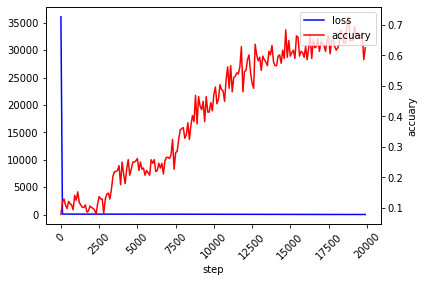

In [2]:
# 无BN 22min
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.layers as layers
import pickle
import numpy as np
import os
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size=256

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#随机旋转，裁切等数据增强
def data_enhace(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, max_delta=0.2)
    x = tf.image.random_brightness(x, max_delta=0.7)
    result = tf.image.random_contrast(x, lower=0.2, upper=1.8)
    return result

#mixup数据增强
def criterion(batch_x, batch_y, batch_size,alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = tf.random_shuffle(batch_size)
    mixed_batchx = lam * batch_x + (1 - lam) * batch_x[index, :]

    batch_y_= lam*batch_y+(1-lam)*batch_y[index]
    return mixed_batchx,batch_y_

#本地载入cifar10数据集
def load_cifar10_batch(cifar10_dataset_folder_path,batch_id):

    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id),mode='rb') as file:
        batch = pickle.load(file, encoding = 'latin1')

    # features and labels
    features = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']

    return  features, labels

#在线载入cifar10数据集
def load_cifar10_batch_online():
    (x_Train, y_Train), (x_Test, y_Test)=cifar10.load_data()
    return x_Train,y_Train,x_Test,y_Test

#cifar10数据集读取器
class Cifar10DataReader():
    def __init__(self, cifar_folder=None, onehot=True):
        self.cifar_folder = cifar_folder
        self.onehot = onehot
        self.data_label_train = None
        self.data_label_test = None
        self.batch_index = 0

        if cifar_folder==None:#在线
            x_train, y_train,x_test,y_test=load_cifar10_batch_online()
            self.data_label_train = list(zip(x_train, y_train))
            self.data_label_test = list(zip(x_test, y_test))
            np.random.shuffle(self.data_label_train)

        else:#本地
            x_train, y_train = load_cifar10_batch(self.cifar_folder, 1)
            for i in range(2,6):
                features,labels = load_cifar10_batch(self.cifar_folder, i)
                x_train, y_train = np.concatenate([x_train, features]),np.concatenate([y_train, labels])
            self.data_label_train = list(zip(x_train, y_train))
            np.random.shuffle(self.data_label_train)

            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

    #批次读取训练集数据
    def next_train_data(self, batch_size=100):
        if self.batch_index < len(self.data_label_train) // batch_size:
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)
        else:
            self.batch_index = 0
            np.random.shuffle(self.data_label_train)
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)

    #读取所有训练集数据
    def all_train_data(self):
        np.random.shuffle(self.data_label_train)
        datum = self.data_label_train
        return self._decode(datum, self.onehot)

    #独热编码
    def _decode(self, datum, onehot):
        rdata = list()
        rlabel = list()
        if onehot:
            for d, l in datum:
                rdata.append(d)
                hot = np.zeros(10)
                hot[int(l)] = 1
                rlabel.append(hot)
        else:
            for d, l in datum:
                rdata.append(d)
                rlabel.append(int(l))
        return rdata, rlabel

    #批次读取测试集数据
    def next_test_data(self, batch_size=100):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test[0:batch_size]

        return self._decode(datum, self.onehot)

    #读取所有测试集数据
    def all_test_data(self):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test

        return self._decode(datum, self.onehot)


#网络结构
def weight_variable(shape):
    weights = tf.get_variable("weights", shape, initializer=tf.contrib.keras.initializers.he_normal())
    #加入l2正则化
    regular=tf.multiply(tf.nn.l2_loss(weights),0.005,name='regular')
    tf.add_to_collection('losses',regular)
    return weights
def bias_variable(shape):
    biases = tf.get_variable("biases", shape, initializer=tf.constant_initializer(0.0))
    return biases
def conv_layer(x, w, b, name, strides, padding = 'SAME'):
    with tf.variable_scope(name):
        w = weight_variable(w)
        b = bias_variable(b)
        conv_and_biased = tf.nn.conv2d(x, w, strides = strides, padding = padding, name = name) + b
    return conv_and_biased
def batch_normalization(inputs, scope, is_training=True, need_relu=True):
    bn = tf.contrib.layers.batch_norm(inputs,
        decay=0.999,
        center=True, # 是否有beta
        scale=True,  # 是否有gamma
        epsilon=0.001,
        activation_fn=None,
        param_initializers=None, # beta, gamma, moving mean and moving variance的优化初始化
        param_regularizers=None, # beta, gamma的正则化优化
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        is_training=is_training,  # 可以让学生实验True和False的区别。
        reuse=None,
        variables_collections=None,
        outputs_collections=None,
        trainable=True,
        batch_weights=None,
        fused=False,
        data_format='NHWC',
        zero_debias_moving_mean=False,
        scope=scope,
        renorm=False,
        renorm_clipping=None,
        renorm_decay=0.99)
    if need_relu:
        bn = tf.nn.relu(bn, name='relu')
    return bn
def maxpooling(x,kernal_size, strides, name):  # 最大池化，前面的是核大小，一般为[1, 2, 2, 1]，后面的strides指的是步长，如[1, 2, 2, 1]。
    return tf.nn.max_pool(x, ksize=kernal_size, strides=strides, padding='SAME',name = name)
def avg_pool(input_feats, k):
    ksize = [1, k, k, 1]
    strides = [1, k, k, 1]
    padding = 'VALID'
    output = tf.nn.avg_pool(input_feats, ksize, strides, padding)  # 平均池化
    return output
def conv_block(input_tensor, kernel_size, filters, stage, block, train_flag,stride2=False):
    nb_filter1, nb_filter2, nb_filter3 = filters  # nb_filter1/2/3分别是64/64/256，三个整数。
    conv_name_base = 'res' + str(stage) + block + '_branch'  # 'res2a_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'  # 'bn2a_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    if stride2==False:
        stride_for_first_conv = [1, 1, 1, 1]  # 。
    else:
        stride_for_first_conv = [1, 2, 2, 1]
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '2a')
    # x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    # x = batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    # x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    shortcut = conv_layer(input_tensor, [1, 1, input_layers, nb_filter3], [nb_filter3], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '1')
    # shortcut = batch_normalization(shortcut, scope=bn_name_base + '1', is_training=train_flag)
    x = tf.add(x, shortcut)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def identity_block(input_tensor, kernel_size, filters, stage, block, train_flag):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2a')
    # x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    # x =  batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    # x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    x = tf.add(x, input_tensor)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def resnet_graph(input_image, architecture,train_flag=True, stage5=False,ttf=True):  # 残差网络函数
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    paddings = tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]])  # 上下左右各补3个0。
    x = tf.pad(input_image, paddings, "CONSTANT")
    w = weight_variable([7, 7, 3, 64])
    b = bias_variable([64])  #
    x = tf.nn.conv2d(x, w, strides = [1, 2, 2, 1], padding = 'VALID', name = 'conv_1') + b
    # x = batch_normalization(x, scope='bn_conv1', is_training=train_flag, need_relu=True)
    C1 = x = maxpooling(x, [1, 3, 3, 1], [1, 2, 2, 1], name='stage1')
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', train_flag=train_flag)  # 结构块。
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_flag=train_flag)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_flag=train_flag, stride2=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_flag=train_flag)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_flag=train_flag)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_flag=train_flag, stride2=True)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]  # block_count=22，即，下句for循环的range是0~22，正好是加23个层。
    for i in range(block_count):  # 加22个层，都是用identity_block函数加。
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_flag=train_flag)
    C4 = x  #
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_flag=train_flag, stride2=True)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_flag=train_flag)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_flag=train_flag)
        output=avg_pool(C5,1)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)#加入dropout
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)
    else:
        C5 = None
        output=avg_pool(C4,2)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)

    return [C1, C2, C3, C4, C5,output]



filepath='C:/Users/zy109/Desktop/1/data/cifar-10-batches-py'
model_save_path='C:/Users/zy109/Desktop/1/cifar10'
data=Cifar10DataReader()
sess=tf.InteractiveSession()

#指数衰减学习率
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(learning_rate=0.001, global_step=global_step, decay_steps=50, decay_rate=0.99, staircase=False)

#占位符
input_image=tf.placeholder(tf.float32,[None,32,32,3])
y_=tf.placeholder(tf.float32,[None,10])
tf_is_train=tf.placeholder(tf.bool,None)
input_image=data_enhace(input_image)#数据增强
input_image,y_=criterion(input_image,y_,batch_size)#mixup

[C1,C2,C3,C4,C5,output]=resnet_graph(input_image,'resnet50',ttf=tf_is_train)

#交叉熵损失
cross_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=output))

tf.add_to_collection('losses',cross_loss)
loss=tf.add_n(tf.get_collection('losses'))
train_step=tf.train.AdamOptimizer(lr).minimize(loss,global_step=global_step)

#正确率
correct_prediction=tf.equal(tf.argmax(output,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))



# 开始训练
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
#读取已经训练好的权重
ckpt = tf.train.get_checkpoint_state(model_save_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

#加载测试集数据
test_data=data.all_test_data()
x_test=np.array(test_data[0])/255
y_test=np.array(test_data[1])

total_loss=[]
total_acc=[]
total_step=[]


# 训练
for i in range(20000):

    #逐批加载训练集数据
    train_data=data.next_train_data(batch_size)
    x_train=np.array(train_data[0])/255
    y_train=np.array(train_data[1])

    train_step.run(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

    if i % 100 == 0:
        # 测试准确率
        train_accuracy = accuracy.eval(feed_dict={input_image: x_train,y_: y_train,tf_is_train:False})
        test_accuracy = accuracy.eval(feed_dict={input_image: x_test,y_: y_test,tf_is_train:False})
        # 该次训练的损失
        loss_value = loss.eval(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

        global_var=sess.run(global_step)
        lr_val=sess.run(lr)
        print("step %d, trainning accuracy， %g , testing accuracy， %g , loss %g  ,lr %g" % (global_var, train_accuracy,test_accuracy, loss_value,lr_val))
        total_step.append(i)
        total_loss.append(loss_value)
        total_acc.append(train_accuracy)



#保存模型
save_path = saver.save(sess,"./cifar10/model.ckpt")
print("save model:{0} Finished".format(save_path))
np.save("cifar10_step",total_step)
np.save("cifar10_loss",total_loss)
np.save("cifar10_acc",total_acc)

#测试
y_log_predict=output.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
test_accuracy = accuracy.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
print("test accuracy %g" % test_accuracy)



# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), y_log_predict.argmax(axis=1))


for i in range(len(y_log_predict)):
        max_value=max(y_log_predict[i])
        for j in range(len(y_log_predict[i])):
            if max_value==y_log_predict[i][j]:
                y_log_predict[i][j]=1
            else:
                y_log_predict[i][j]=0

# 精确率
from sklearn.metrics import precision_score
ps=precision_score(y_test, y_log_predict,average=None)
np.save("cifar10_precision_score",ps)

#召回率
from sklearn.metrics import recall_score
rs=recall_score(y_test, y_log_predict,average=None)
np.save("cifar10_recall_score",rs)

print("precision score:",ps)
print("recall score:",rs)

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(total_step, total_loss, color="blue", label="loss")
ax1.set_xlabel("step")


ax2 = ax1.twinx()
ax2.plot(total_step, total_acc, color="red", label="accuary")
ax2.set_ylabel("accuary")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()


TensorFlow 1.x selected.
170500096/170498071 [==============================] - 4s 0us/step
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 1, trainning accuracy， 0.148438 , testing accuracy， 0.1213 , loss 81.5084  ,lr 0.000999799
step 101, trainning accuracy， 0.320312 , testing accuracy， 0.3145 , loss 52.5669  ,lr 0.000979903
step 201, trainning accuracy， 0.386719 , testing accuracy， 0.3973 , loss 31.415  ,l

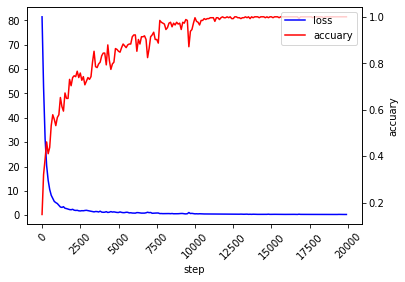

In [1]:
# 无center scale 36min
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.layers as layers
import pickle
import numpy as np
import os
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size=256

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#随机旋转，裁切等数据增强
def data_enhace(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, max_delta=0.2)
    x = tf.image.random_brightness(x, max_delta=0.7)
    result = tf.image.random_contrast(x, lower=0.2, upper=1.8)
    return result

#mixup数据增强
def criterion(batch_x, batch_y, batch_size,alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = tf.random_shuffle(batch_size)
    mixed_batchx = lam * batch_x + (1 - lam) * batch_x[index, :]

    batch_y_= lam*batch_y+(1-lam)*batch_y[index]
    return mixed_batchx,batch_y_

#本地载入cifar10数据集
def load_cifar10_batch(cifar10_dataset_folder_path,batch_id):

    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id),mode='rb') as file:
        batch = pickle.load(file, encoding = 'latin1')

    # features and labels
    features = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']

    return  features, labels

#在线载入cifar10数据集
def load_cifar10_batch_online():
    (x_Train, y_Train), (x_Test, y_Test)=cifar10.load_data()
    return x_Train,y_Train,x_Test,y_Test

#cifar10数据集读取器
class Cifar10DataReader():
    def __init__(self, cifar_folder=None, onehot=True):
        self.cifar_folder = cifar_folder
        self.onehot = onehot
        self.data_label_train = None
        self.data_label_test = None
        self.batch_index = 0

        if cifar_folder==None:#在线
            x_train, y_train,x_test,y_test=load_cifar10_batch_online()
            self.data_label_train = list(zip(x_train, y_train))
            self.data_label_test = list(zip(x_test, y_test))
            np.random.shuffle(self.data_label_train)

        else:#本地
            x_train, y_train = load_cifar10_batch(self.cifar_folder, 1)
            for i in range(2,6):
                features,labels = load_cifar10_batch(self.cifar_folder, i)
                x_train, y_train = np.concatenate([x_train, features]),np.concatenate([y_train, labels])
            self.data_label_train = list(zip(x_train, y_train))
            np.random.shuffle(self.data_label_train)

            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

    #批次读取训练集数据
    def next_train_data(self, batch_size=100):
        if self.batch_index < len(self.data_label_train) // batch_size:
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)
        else:
            self.batch_index = 0
            np.random.shuffle(self.data_label_train)
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)

    #读取所有训练集数据
    def all_train_data(self):
        np.random.shuffle(self.data_label_train)
        datum = self.data_label_train
        return self._decode(datum, self.onehot)

    #独热编码
    def _decode(self, datum, onehot):
        rdata = list()
        rlabel = list()
        if onehot:
            for d, l in datum:
                rdata.append(d)
                hot = np.zeros(10)
                hot[int(l)] = 1
                rlabel.append(hot)
        else:
            for d, l in datum:
                rdata.append(d)
                rlabel.append(int(l))
        return rdata, rlabel

    #批次读取测试集数据
    def next_test_data(self, batch_size=100):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test[0:batch_size]

        return self._decode(datum, self.onehot)

    #读取所有测试集数据
    def all_test_data(self):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test

        return self._decode(datum, self.onehot)


#网络结构
def weight_variable(shape):
    weights = tf.get_variable("weights", shape, initializer=tf.contrib.keras.initializers.he_normal())
    #加入l2正则化
    regular=tf.multiply(tf.nn.l2_loss(weights),0.005,name='regular')
    tf.add_to_collection('losses',regular)
    return weights
def bias_variable(shape):
    biases = tf.get_variable("biases", shape, initializer=tf.constant_initializer(0.0))
    return biases
def conv_layer(x, w, b, name, strides, padding = 'SAME'):
    with tf.variable_scope(name):
        w = weight_variable(w)
        b = bias_variable(b)
        conv_and_biased = tf.nn.conv2d(x, w, strides = strides, padding = padding, name = name) + b
    return conv_and_biased
def batch_normalization(inputs, scope, is_training=True, need_relu=True):
    bn = tf.contrib.layers.batch_norm(inputs,
        decay=0.999,
        center=False, # 是否有beta
        scale=False,  # 是否有gamma
        epsilon=0.001,
        activation_fn=None,
        param_initializers=None, # beta, gamma, moving mean and moving variance的优化初始化
        param_regularizers=None, # beta, gamma的正则化优化
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        is_training=is_training,  # 可以让学生实验True和False的区别。
        reuse=None,
        variables_collections=None,
        outputs_collections=None,
        trainable=True,
        batch_weights=None,
        fused=False,
        data_format='NHWC',
        zero_debias_moving_mean=False,
        scope=scope,
        renorm=False,
        renorm_clipping=None,
        renorm_decay=0.99)
    if need_relu:
        bn = tf.nn.relu(bn, name='relu')
    return bn
def maxpooling(x,kernal_size, strides, name):  # 最大池化，前面的是核大小，一般为[1, 2, 2, 1]，后面的strides指的是步长，如[1, 2, 2, 1]。
    return tf.nn.max_pool(x, ksize=kernal_size, strides=strides, padding='SAME',name = name)
def avg_pool(input_feats, k):
    ksize = [1, k, k, 1]
    strides = [1, k, k, 1]
    padding = 'VALID'
    output = tf.nn.avg_pool(input_feats, ksize, strides, padding)  # 平均池化
    return output
def conv_block(input_tensor, kernel_size, filters, stage, block, train_flag,stride2=False):
    nb_filter1, nb_filter2, nb_filter3 = filters  # nb_filter1/2/3分别是64/64/256，三个整数。
    conv_name_base = 'res' + str(stage) + block + '_branch'  # 'res2a_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'  # 'bn2a_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    if stride2==False:
        stride_for_first_conv = [1, 1, 1, 1]  # 。
    else:
        stride_for_first_conv = [1, 2, 2, 1]
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x = batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    shortcut = conv_layer(input_tensor, [1, 1, input_layers, nb_filter3], [nb_filter3], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '1')
    shortcut = batch_normalization(shortcut, scope=bn_name_base + '1', is_training=train_flag)
    x = tf.add(x, shortcut)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def identity_block(input_tensor, kernel_size, filters, stage, block, train_flag):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x =  batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    x = tf.add(x, input_tensor)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def resnet_graph(input_image, architecture,train_flag=True, stage5=False,ttf=True):  # 残差网络函数
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    paddings = tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]])  # 上下左右各补3个0。
    x = tf.pad(input_image, paddings, "CONSTANT")
    w = weight_variable([7, 7, 3, 64])
    b = bias_variable([64])  #
    x = tf.nn.conv2d(x, w, strides = [1, 2, 2, 1], padding = 'VALID', name = 'conv_1') + b
    x = batch_normalization(x, scope='bn_conv1', is_training=train_flag, need_relu=True)
    C1 = x = maxpooling(x, [1, 3, 3, 1], [1, 2, 2, 1], name='stage1')
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', train_flag=train_flag)  # 结构块。
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_flag=train_flag)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_flag=train_flag, stride2=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_flag=train_flag)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_flag=train_flag)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_flag=train_flag, stride2=True)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]  # block_count=22，即，下句for循环的range是0~22，正好是加23个层。
    for i in range(block_count):  # 加22个层，都是用identity_block函数加。
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_flag=train_flag)
    C4 = x  #
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_flag=train_flag, stride2=True)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_flag=train_flag)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_flag=train_flag)
        output=avg_pool(C5,1)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)#加入dropout
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)
    else:
        C5 = None
        output=avg_pool(C4,2)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)

    return [C1, C2, C3, C4, C5,output]



filepath='C:/Users/zy109/Desktop/1/data/cifar-10-batches-py'
model_save_path='C:/Users/zy109/Desktop/1/cifar10'
data=Cifar10DataReader()
sess=tf.InteractiveSession()

#指数衰减学习率
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(learning_rate=0.001, global_step=global_step, decay_steps=50, decay_rate=0.99, staircase=False)

#占位符
input_image=tf.placeholder(tf.float32,[None,32,32,3])
y_=tf.placeholder(tf.float32,[None,10])
tf_is_train=tf.placeholder(tf.bool,None)
input_image=data_enhace(input_image)#数据增强
input_image,y_=criterion(input_image,y_,batch_size)#mixup

[C1,C2,C3,C4,C5,output]=resnet_graph(input_image,'resnet50',ttf=tf_is_train)

#交叉熵损失
cross_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=output))

tf.add_to_collection('losses',cross_loss)
loss=tf.add_n(tf.get_collection('losses'))
train_step=tf.train.AdamOptimizer(lr).minimize(loss,global_step=global_step)

#正确率
correct_prediction=tf.equal(tf.argmax(output,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))



# 开始训练
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
#读取已经训练好的权重
ckpt = tf.train.get_checkpoint_state(model_save_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

#加载测试集数据
test_data=data.all_test_data()
x_test=np.array(test_data[0])/255
y_test=np.array(test_data[1])

total_loss=[]
total_acc=[]
total_step=[]


# 训练
for i in range(20000):

    #逐批加载训练集数据
    train_data=data.next_train_data(batch_size)
    x_train=np.array(train_data[0])/255
    y_train=np.array(train_data[1])

    train_step.run(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

    if i % 100 == 0:
        # 测试准确率
        train_accuracy = accuracy.eval(feed_dict={input_image: x_train,y_: y_train,tf_is_train:False})
        test_accuracy = accuracy.eval(feed_dict={input_image: x_test,y_: y_test,tf_is_train:False})
        # 该次训练的损失
        loss_value = loss.eval(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

        global_var=sess.run(global_step)
        lr_val=sess.run(lr)
        print("step %d, trainning accuracy， %g , testing accuracy， %g , loss %g  ,lr %g" % (global_var, train_accuracy,test_accuracy, loss_value,lr_val))
        total_step.append(i)
        total_loss.append(loss_value)
        total_acc.append(train_accuracy)



#保存模型
save_path = saver.save(sess,"./cifar10/model.ckpt")
print("save model:{0} Finished".format(save_path))
np.save("cifar10_step",total_step)
np.save("cifar10_loss",total_loss)
np.save("cifar10_acc",total_acc)

#测试
y_log_predict=output.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
test_accuracy = accuracy.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
print("test accuracy %g" % test_accuracy)



# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), y_log_predict.argmax(axis=1))


for i in range(len(y_log_predict)):
        max_value=max(y_log_predict[i])
        for j in range(len(y_log_predict[i])):
            if max_value==y_log_predict[i][j]:
                y_log_predict[i][j]=1
            else:
                y_log_predict[i][j]=0

# 精确率
from sklearn.metrics import precision_score
ps=precision_score(y_test, y_log_predict,average=None)
np.save("cifar10_precision_score",ps)

#召回率
from sklearn.metrics import recall_score
rs=recall_score(y_test, y_log_predict,average=None)
np.save("cifar10_recall_score",rs)

print("precision score:",ps)
print("recall score:",rs)

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(total_step, total_loss, color="blue", label="loss")
ax1.set_xlabel("step")


ax2 = ax1.twinx()
ax2.plot(total_step, total_acc, color="red", label="accuary")
ax2.set_ylabel("accuary")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()


TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 1, trainning accuracy， 0.160156 , testing accuracy， 0.1232 , loss 80.9494  ,lr 0.000999799
step 101, trainning accuracy， 0.351562 , testing accuracy， 0.324 , loss 50.8969  ,lr 0.000979903
step 201, trainning accuracy， 0.410156 , testing accuracy， 0.4074 , loss 30.2323  ,lr 0.000960403
step 301, trainning accuracy， 0.402344 , testing accu

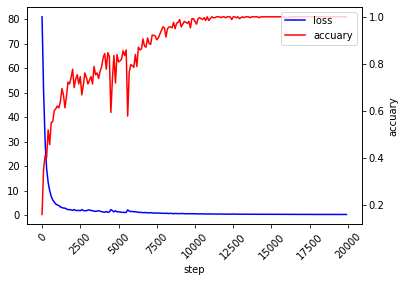

In [1]:
# zero_debias_moving_mean=True, 17min
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.layers as layers
import pickle
import numpy as np
import os
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size=256

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#随机旋转，裁切等数据增强
def data_enhace(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_hue(x, max_delta=0.2)
    x = tf.image.random_brightness(x, max_delta=0.7)
    result = tf.image.random_contrast(x, lower=0.2, upper=1.8)
    return result

#mixup数据增强
def criterion(batch_x, batch_y, batch_size,alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = tf.random_shuffle(batch_size)
    mixed_batchx = lam * batch_x + (1 - lam) * batch_x[index, :]

    batch_y_= lam*batch_y+(1-lam)*batch_y[index]
    return mixed_batchx,batch_y_

#本地载入cifar10数据集
def load_cifar10_batch(cifar10_dataset_folder_path,batch_id):

    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id),mode='rb') as file:
        batch = pickle.load(file, encoding = 'latin1')

    # features and labels
    features = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']

    return  features, labels

#在线载入cifar10数据集
def load_cifar10_batch_online():
    (x_Train, y_Train), (x_Test, y_Test)=cifar10.load_data()
    return x_Train,y_Train,x_Test,y_Test

#cifar10数据集读取器
class Cifar10DataReader():
    def __init__(self, cifar_folder=None, onehot=True):
        self.cifar_folder = cifar_folder
        self.onehot = onehot
        self.data_label_train = None
        self.data_label_test = None
        self.batch_index = 0

        if cifar_folder==None:#在线
            x_train, y_train,x_test,y_test=load_cifar10_batch_online()
            self.data_label_train = list(zip(x_train, y_train))
            self.data_label_test = list(zip(x_test, y_test))
            np.random.shuffle(self.data_label_train)

        else:#本地
            x_train, y_train = load_cifar10_batch(self.cifar_folder, 1)
            for i in range(2,6):
                features,labels = load_cifar10_batch(self.cifar_folder, i)
                x_train, y_train = np.concatenate([x_train, features]),np.concatenate([y_train, labels])
            self.data_label_train = list(zip(x_train, y_train))
            np.random.shuffle(self.data_label_train)

            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

    #批次读取训练集数据
    def next_train_data(self, batch_size=100):
        if self.batch_index < len(self.data_label_train) // batch_size:
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)
        else:
            self.batch_index = 0
            np.random.shuffle(self.data_label_train)
            datum = self.data_label_train[self.batch_index * batch_size:(self.batch_index + 1) * batch_size]
            self.batch_index += 1
            return self._decode(datum, self.onehot)

    #读取所有训练集数据
    def all_train_data(self):
        np.random.shuffle(self.data_label_train)
        datum = self.data_label_train
        return self._decode(datum, self.onehot)

    #独热编码
    def _decode(self, datum, onehot):
        rdata = list()
        rlabel = list()
        if onehot:
            for d, l in datum:
                rdata.append(d)
                hot = np.zeros(10)
                hot[int(l)] = 1
                rlabel.append(hot)
        else:
            for d, l in datum:
                rdata.append(d)
                rlabel.append(int(l))
        return rdata, rlabel

    #批次读取测试集数据
    def next_test_data(self, batch_size=100):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test[0:batch_size]

        return self._decode(datum, self.onehot)

    #读取所有测试集数据
    def all_test_data(self):
        if self.data_label_test is None:
            with open(self.cifar_folder + '/test_batch', mode = 'rb') as file:
                batch = pickle.load(file, encoding='latin1')
                data = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
                labels = batch['labels']
            self.data_label_test = list(zip(data, labels))

        np.random.shuffle(self.data_label_test)
        datum = self.data_label_test

        return self._decode(datum, self.onehot)


#网络结构
def weight_variable(shape):
    weights = tf.get_variable("weights", shape, initializer=tf.contrib.keras.initializers.he_normal())
    #加入l2正则化
    regular=tf.multiply(tf.nn.l2_loss(weights),0.005,name='regular')
    tf.add_to_collection('losses',regular)
    return weights
def bias_variable(shape):
    biases = tf.get_variable("biases", shape, initializer=tf.constant_initializer(0.0))
    return biases
def conv_layer(x, w, b, name, strides, padding = 'SAME'):
    with tf.variable_scope(name):
        w = weight_variable(w)
        b = bias_variable(b)
        conv_and_biased = tf.nn.conv2d(x, w, strides = strides, padding = padding, name = name) + b
    return conv_and_biased
def batch_normalization(inputs, scope, is_training=True, need_relu=True):
    bn = tf.contrib.layers.batch_norm(inputs,
        decay=0.999,
        center=True, # 是否有beta
        scale=True,  # 是否有gamma
        epsilon=0.001,
        activation_fn=None,
        param_initializers=None, # beta, gamma, moving mean and moving variance的优化初始化
        param_regularizers=None, # beta, gamma的正则化优化
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        is_training=is_training,  # 可以让学生实验True和False的区别。
        reuse=None,
        variables_collections=None,
        outputs_collections=None,
        trainable=True,
        batch_weights=None,
        fused=False,
        data_format='NHWC',
        zero_debias_moving_mean=True,
        scope=scope,
        renorm=False,
        renorm_clipping=None,
        renorm_decay=0.99)
    if need_relu:
        bn = tf.nn.relu(bn, name='relu')
    return bn
def maxpooling(x,kernal_size, strides, name):  # 最大池化，前面的是核大小，一般为[1, 2, 2, 1]，后面的strides指的是步长，如[1, 2, 2, 1]。
    return tf.nn.max_pool(x, ksize=kernal_size, strides=strides, padding='SAME',name = name)
def avg_pool(input_feats, k):
    ksize = [1, k, k, 1]
    strides = [1, k, k, 1]
    padding = 'VALID'
    output = tf.nn.avg_pool(input_feats, ksize, strides, padding)  # 平均池化
    return output
def conv_block(input_tensor, kernel_size, filters, stage, block, train_flag,stride2=False):
    nb_filter1, nb_filter2, nb_filter3 = filters  # nb_filter1/2/3分别是64/64/256，三个整数。
    conv_name_base = 'res' + str(stage) + block + '_branch'  # 'res2a_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'  # 'bn2a_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    if stride2==False:
        stride_for_first_conv = [1, 1, 1, 1]  # 。
    else:
        stride_for_first_conv = [1, 2, 2, 1]
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x = batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    shortcut = conv_layer(input_tensor, [1, 1, input_layers, nb_filter3], [nb_filter3], strides=stride_for_first_conv, padding='SAME', name=conv_name_base + '1')
    shortcut = batch_normalization(shortcut, scope=bn_name_base + '1', is_training=train_flag)
    x = tf.add(x, shortcut)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def identity_block(input_tensor, kernel_size, filters, stage, block, train_flag):
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    _, _, _, input_layers = input_tensor.get_shape().as_list()
    x = conv_layer(input_tensor, [1, 1, input_layers, nb_filter1], [nb_filter1], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2a')
    x = batch_normalization(x, scope=bn_name_base + '2a', is_training=train_flag)
    x = conv_layer(x, [kernel_size, kernel_size, nb_filter1, nb_filter2], [nb_filter2], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2b')
    x =  batch_normalization(x, scope=bn_name_base + '2b', is_training=train_flag)
    x = conv_layer(x, [1, 1, nb_filter2, nb_filter3], [nb_filter3], strides=[1, 1, 1, 1], padding='SAME', name=conv_name_base + '2c')
    x = batch_normalization(x, scope=bn_name_base + '2c', is_training=train_flag, need_relu=False)
    x = tf.add(x, input_tensor)
    x = tf.nn.relu(x, name='res' + str(stage) + block + '_out')
    #x = layers.dropout(x, rate=0.4, training=train_flag)
    return x
def resnet_graph(input_image, architecture,train_flag=True, stage5=False,ttf=True):  # 残差网络函数
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    paddings = tf.constant([[0, 0], [3, 3], [3, 3], [0, 0]])  # 上下左右各补3个0。
    x = tf.pad(input_image, paddings, "CONSTANT")
    w = weight_variable([7, 7, 3, 64])
    b = bias_variable([64])  #
    x = tf.nn.conv2d(x, w, strides = [1, 2, 2, 1], padding = 'VALID', name = 'conv_1') + b
    x = batch_normalization(x, scope='bn_conv1', is_training=train_flag, need_relu=True)
    C1 = x = maxpooling(x, [1, 3, 3, 1], [1, 2, 2, 1], name='stage1')
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', train_flag=train_flag)  # 结构块。
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_flag=train_flag)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_flag=train_flag, stride2=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_flag=train_flag)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_flag=train_flag)
    x=tf.layers.dropout(x,rate=0.5,training=ttf)#加入dropout
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_flag=train_flag)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_flag=train_flag, stride2=True)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]  # block_count=22，即，下句for循环的range是0~22，正好是加23个层。
    for i in range(block_count):  # 加22个层，都是用identity_block函数加。
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_flag=train_flag)
    C4 = x  #
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_flag=train_flag, stride2=True)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_flag=train_flag)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_flag=train_flag)
        output=avg_pool(C5,1)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)#加入dropout
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)
    else:
        C5 = None
        output=avg_pool(C4,2)
        output=tf.layers.dropout(output,rate=0.5,training=ttf)
        fo= layers.Dense(10)

        output=tf.layers.flatten(output)
        output = fo(output)

    return [C1, C2, C3, C4, C5,output]



filepath='C:/Users/zy109/Desktop/1/data/cifar-10-batches-py'
model_save_path='C:/Users/zy109/Desktop/1/cifar10'
data=Cifar10DataReader()
sess=tf.InteractiveSession()

#指数衰减学习率
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(learning_rate=0.001, global_step=global_step, decay_steps=50, decay_rate=0.99, staircase=False)

#占位符
input_image=tf.placeholder(tf.float32,[None,32,32,3])
y_=tf.placeholder(tf.float32,[None,10])
tf_is_train=tf.placeholder(tf.bool,None)
input_image=data_enhace(input_image)#数据增强
input_image,y_=criterion(input_image,y_,batch_size)#mixup

[C1,C2,C3,C4,C5,output]=resnet_graph(input_image,'resnet50',ttf=tf_is_train)

#交叉熵损失
cross_loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_,logits=output))

tf.add_to_collection('losses',cross_loss)
loss=tf.add_n(tf.get_collection('losses'))
train_step=tf.train.AdamOptimizer(lr).minimize(loss,global_step=global_step)

#正确率
correct_prediction=tf.equal(tf.argmax(output,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))



# 开始训练
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
#读取已经训练好的权重
ckpt = tf.train.get_checkpoint_state(model_save_path)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)

#加载测试集数据
test_data=data.all_test_data()
x_test=np.array(test_data[0])/255
y_test=np.array(test_data[1])

total_loss=[]
total_acc=[]
total_step=[]


# 训练
for i in range(20000):

    #逐批加载训练集数据
    train_data=data.next_train_data(batch_size)
    x_train=np.array(train_data[0])/255
    y_train=np.array(train_data[1])

    train_step.run(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

    if i % 100 == 0:
        # 测试准确率
        train_accuracy = accuracy.eval(feed_dict={input_image: x_train,y_: y_train,tf_is_train:False})
        test_accuracy = accuracy.eval(feed_dict={input_image: x_test,y_: y_test,tf_is_train:False})
        # 该次训练的损失
        loss_value = loss.eval(feed_dict = {input_image: x_train,
                                    y_: y_train,tf_is_train:True})

        global_var=sess.run(global_step)
        lr_val=sess.run(lr)
        print("step %d, trainning accuracy， %g , testing accuracy， %g , loss %g  ,lr %g" % (global_var, train_accuracy,test_accuracy, loss_value,lr_val))
        total_step.append(i)
        total_loss.append(loss_value)
        total_acc.append(train_accuracy)



#保存模型
save_path = saver.save(sess,"./cifar10/model.ckpt")
print("save model:{0} Finished".format(save_path))
np.save("cifar10_step",total_step)
np.save("cifar10_loss",total_loss)
np.save("cifar10_acc",total_acc)

#测试
y_log_predict=output.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
test_accuracy = accuracy.eval(feed_dict = {input_image: x_test, y_: y_test,tf_is_train:False})
print("test accuracy %g" % test_accuracy)



# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), y_log_predict.argmax(axis=1))


for i in range(len(y_log_predict)):
        max_value=max(y_log_predict[i])
        for j in range(len(y_log_predict[i])):
            if max_value==y_log_predict[i][j]:
                y_log_predict[i][j]=1
            else:
                y_log_predict[i][j]=0

# 精确率
from sklearn.metrics import precision_score
ps=precision_score(y_test, y_log_predict,average=None)
np.save("cifar10_precision_score",ps)

#召回率
from sklearn.metrics import recall_score
rs=recall_score(y_test, y_log_predict,average=None)
np.save("cifar10_recall_score",rs)

print("precision score:",ps)
print("recall score:",rs)

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(total_step, total_loss, color="blue", label="loss")
ax1.set_xlabel("step")


ax2 = ax1.twinx()
ax2.plot(total_step, total_acc, color="red", label="accuary")
ax2.set_ylabel("accuary")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()
